In [1]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/bookcrossing'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [3]:
[df, df_train,df_valid,df,df_ratings,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/reads.pkl','rb'))

In [4]:
df.shape

(433671, 22)

In [5]:
df.head()

,userId,itemId,rating,num_ratings_per_user_gt_20,num_ratings_per_item_gt_200,flag_clean_considered,Location,Age,Book-Title,Book-Author,...,random_dstype,user_idx,item_idx,dstype_random_train,dstype_random_valid,location_idx,age_idx,title_idx,author_idx,publisher_idx
49299,26538,0590010891,10,True,False,False,"rawlins, wyoming, usa",32.0,Star Wars Episode I: The Phantom Menace,Patricia C. Wrede,...,train,1,1,1,0,1,1,1,1,1
339650,213826,1562764047,7,False,False,False,"university city, missouri, usa",40.0,How the Internet Works (How It Works Series (E...,Preston Gralla,...,train,2,2,1,0,2,2,2,2,2
358933,227054,0553284789,7,False,False,False,"nampa, idaho, usa",27.0,F Is for Fugitive (Kinsey Millhone Mysteries (...,Sue Grafton,...,train,3,3,1,0,3,3,3,3,3
393023,248656,0380977788,10,True,False,False,"altamonte springs, florida, usa",34.0,Coraline,Neil Gaiman,...,train,4,4,1,0,4,4,4,4,4
347702,220091,0425172996,8,True,False,False,"san diego, california, usa",NaN,Vector,Robin Cook,...,train,5,5,1,0,5,0,5,5,5


In [6]:
df_train=df.loc[df['random_dstype']=='train']
df_valid=df.loc[df['random_dstype']!='train']

In [7]:
df_train.head().T

,49299,339650,358933,393023,347702
userId,26538,213826,227054,248656,220091
itemId,0590010891,1562764047,0553284789,0380977788,0425172996
rating,10,7,7,10,8
num_ratings_per_user_gt_20,True,False,False,True,True
num_ratings_per_item_gt_200,False,False,False,False,False
flag_clean_considered,False,False,False,False,False
Location,"rawlins, wyoming, usa","university city, missouri, usa","nampa, idaho, usa","altamonte springs, florida, usa","san diego, california, usa"
Age,32,40,27,34,NaN
Book-Title,Star Wars Episode I: The Phantom Menace,How the Internet Works (How It Works Series (E...,F Is for Fugitive (Kinsey Millhone Mysteries (...,Coraline,Vector
Book-Author,Patricia C. Wrede,Preston Gralla,Sue Grafton,Neil Gaiman,Robin Cook


In [8]:
df_train.shape,df_valid.shape

((390303, 22), (43368, 22))

### Add the autoencoder features

In [9]:
import pickle

In [10]:
[df_train_user_autoenc,df_valid_user_autoenc,user_mtx_1_weights,user_mtx_2_weights]=\
    pickle.load(open(f'{DATAPATH}/inter/user_autoenc_weights.pkl','rb'))

In [11]:
[df_train_item_autoenc, df_valid_item_autoenc,item_mtx_1_weights,item_mtx_2_weights]=\
    pickle.load(open(f'{DATAPATH}/inter/item_autoenc_weights.pkl','rb'))

In [12]:
df_train_user_autoenc.shape, type(df_train_user_autoenc),df_train_user_autoenc.head()

((77806, 11),
 pandas.core.frame.DataFrame,
    user_idx  user_autoenc0  user_autoenc1  user_autoenc2  user_autoenc3  \
 0         0      -1.892300       1.902252      -1.564169      -1.901883   
 1         1      -1.686263       1.694752      -1.398009      -1.695426   
 2         2      -1.989719       2.000360      -1.642692      -1.999496   
 3         3      -1.736229       1.745061      -1.438396      -1.745506   
 4         4      -1.773188       1.782292      -1.468106      -1.782527   
 
    user_autoenc4  user_autoenc5  user_autoenc6  user_autoenc7  user_autoenc8  \
 0       1.871288      -1.915076      -1.498631      -1.815667       1.510823   
 1       1.667029      -1.706558      -1.339383      -1.617516       1.350429   
 2       1.967867      -2.013657      -1.573877      -1.909373       1.586619   
 3       1.716551      -1.757121      -1.378085      -1.665560       1.389419   
 4       1.753202      -1.794527      -1.406562      -1.701115       1.418095   
 
    user_a

In [13]:
df_valid_user_autoenc.shape, type(df_valid_user_autoenc),df_valid_user_autoenc.head()

((77806, 11),
 pandas.core.frame.DataFrame,
    user_idx  user_autoenc0  user_autoenc1  user_autoenc2  user_autoenc3  \
 0         0      -1.686263       1.694752      -1.398009      -1.695426   
 1         1      -1.686263       1.694752      -1.398009      -1.695426   
 2         2      -1.686277       1.694766      -1.398021      -1.695440   
 3         3      -1.686269       1.694758      -1.398014      -1.695432   
 4         4      -1.686263       1.694752      -1.398009      -1.695426   
 
    user_autoenc4  user_autoenc5  user_autoenc6  user_autoenc7  user_autoenc8  \
 0       1.667029      -1.706558      -1.339383      -1.617516       1.350429   
 1       1.667029      -1.706558      -1.339383      -1.617516       1.350429   
 2       1.667043      -1.706572      -1.339395      -1.617529       1.350440   
 3       1.667034      -1.706564      -1.339388      -1.617521       1.350434   
 4       1.667029      -1.706558      -1.339383      -1.617516       1.350429   
 
    user_a

In [14]:
df_train_item_autoenc.shape, type(df_train_item_autoenc),df_train_item_autoenc.head()

((185974, 26),
 pandas.core.frame.DataFrame,
    item_idx  item_autoenc0  item_autoenc1  item_autoenc2  item_autoenc3  \
 0         0       1.579132       1.517978       1.578589      -1.540997   
 1         1       1.569089       1.508334       1.568551      -1.531216   
 2         2       1.585941       1.524516       1.585391      -1.547614   
 3         3       1.584902       1.523516       1.584351      -1.546593   
 4         4       1.574386       1.513422       1.573842      -1.536364   
 
    item_autoenc4  item_autoenc5  item_autoenc6  item_autoenc7  item_autoenc8  \
 0       1.538934      -1.536199      -1.519847      -1.565494      -1.585846   
 1       1.529148      -1.526430      -1.510185      -1.555542      -1.575764   
 2       1.545570      -1.542825      -1.526399      -1.572234      -1.592677   
 3       1.544561      -1.541814      -1.525400      -1.571202      -1.591634   
 4       1.534310      -1.531584      -1.515284      -1.560782      -1.581078   
 
    ...  

In [15]:
df_valid_item_autoenc.shape, type(df_valid_item_autoenc),df_valid_item_autoenc.head()

((185974, 26),
 pandas.core.frame.DataFrame,
    item_idx  item_autoenc0  item_autoenc1  item_autoenc2  item_autoenc3  \
 0         0       1.569107       1.508351       1.568569      -1.531233   
 1         1       1.569089       1.508334       1.568551      -1.531216   
 2         2       1.569945       1.509156       1.569407      -1.532050   
 3         3       1.570643       1.509825       1.570102      -1.532723   
 4         4       1.569108       1.508352       1.568570      -1.531234   
 
    item_autoenc4  item_autoenc5  item_autoenc6  item_autoenc7  item_autoenc8  \
 0       1.529166      -1.526447      -1.510202      -1.555560      -1.575782   
 1       1.529148      -1.526430      -1.510185      -1.555542      -1.575764   
 2       1.529982      -1.527262      -1.511008      -1.556391      -1.576623   
 3       1.530662      -1.527941      -1.511679      -1.557078      -1.577322   
 4       1.529166      -1.526448      -1.510203      -1.555561      -1.575783   
 
    ...  

In [16]:
df_valid_user_autoenc.isnull().any()

user_idx         False
user_autoenc0    False
user_autoenc1    False
user_autoenc2    False
user_autoenc3    False
user_autoenc4    False
user_autoenc5    False
user_autoenc6    False
user_autoenc7    False
user_autoenc8    False
user_autoenc9    False
dtype: bool

In [17]:
df_valid.isnull().sum()

userId                             0
itemId                             0
rating                             0
num_ratings_per_user_gt_20         0
num_ratings_per_item_gt_200        0
flag_clean_considered              0
Location                           0
Age                            12852
Book-Title                      5028
Book-Author                     5028
Year-Of-Publication             5028
Publisher                       5028
random_dstype                      0
user_idx                           0
item_idx                           0
dstype_random_train                0
dstype_random_valid                0
location_idx                       0
age_idx                            0
title_idx                          0
author_idx                         0
publisher_idx                      0
dtype: int64

In [18]:
df_train.isnull().sum()

userId                              0
itemId                              0
rating                              0
num_ratings_per_user_gt_20          0
num_ratings_per_item_gt_200         0
flag_clean_considered               0
Location                            0
Age                            115542
Book-Title                      44801
Book-Author                     44802
Year-Of-Publication             44801
Publisher                       44803
random_dstype                       0
user_idx                            0
item_idx                            0
dstype_random_train                 0
dstype_random_valid                 0
location_idx                        0
age_idx                             0
title_idx                           0
author_idx                          0
publisher_idx                       0
dtype: int64

In [19]:
df_train.shape, df_valid.shape

((390303, 22), (43368, 22))

In [20]:
df_train.dtypes

userId                           int64
itemId                          object
rating                           int64
num_ratings_per_user_gt_20        bool
num_ratings_per_item_gt_200       bool
flag_clean_considered             bool
Location                        object
Age                            float64
Book-Title                      object
Book-Author                     object
Year-Of-Publication             object
Publisher                       object
random_dstype                   object
user_idx                         int64
item_idx                         int64
dstype_random_train              int64
dstype_random_valid              int64
location_idx                     int64
age_idx                          int64
title_idx                        int64
author_idx                       int64
publisher_idx                    int64
dtype: object

In [21]:
df_train.head()

,userId,itemId,rating,num_ratings_per_user_gt_20,num_ratings_per_item_gt_200,flag_clean_considered,Location,Age,Book-Title,Book-Author,...,random_dstype,user_idx,item_idx,dstype_random_train,dstype_random_valid,location_idx,age_idx,title_idx,author_idx,publisher_idx
49299,26538,0590010891,10,True,False,False,"rawlins, wyoming, usa",32.0,Star Wars Episode I: The Phantom Menace,Patricia C. Wrede,...,train,1,1,1,0,1,1,1,1,1
339650,213826,1562764047,7,False,False,False,"university city, missouri, usa",40.0,How the Internet Works (How It Works Series (E...,Preston Gralla,...,train,2,2,1,0,2,2,2,2,2
358933,227054,0553284789,7,False,False,False,"nampa, idaho, usa",27.0,F Is for Fugitive (Kinsey Millhone Mysteries (...,Sue Grafton,...,train,3,3,1,0,3,3,3,3,3
393023,248656,0380977788,10,True,False,False,"altamonte springs, florida, usa",34.0,Coraline,Neil Gaiman,...,train,4,4,1,0,4,4,4,4,4
347702,220091,0425172996,8,True,False,False,"san diego, california, usa",NaN,Vector,Robin Cook,...,train,5,5,1,0,5,0,5,5,5


In [22]:
df_train=pd.merge(df_train,df_train_item_autoenc,on='item_idx',how='left')

In [23]:
df_train.shape

(390303, 47)

In [24]:
print(df_valid.shape)
df_valid=pd.merge(df_valid,df_valid_item_autoenc,on='item_idx',how='left')
df_valid.shape

(43368, 22)


(43368, 47)

In [25]:
df_valid.shape

(43368, 47)

In [26]:
print(df_valid.shape)
df_valid=pd.merge(df_valid,df_valid_user_autoenc,on='user_idx',how='left')
df_valid.shape

(43368, 47)


(43368, 57)

In [27]:
print(df_train.shape)
df_train=pd.merge(df_train,df_train_user_autoenc,on='user_idx',how='left')
df_train.shape

(390303, 47)


(390303, 57)

In [28]:
df_train.columns

Index(['userId', 'itemId', 'rating', 'num_ratings_per_user_gt_20',
       'num_ratings_per_item_gt_200', 'flag_clean_considered', 'Location',
       'Age', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'random_dstype', 'user_idx', 'item_idx', 'dstype_random_train',
       'dstype_random_valid', 'location_idx', 'age_idx', 'title_idx',
       'author_idx', 'publisher_idx', 'item_autoenc0', 'item_autoenc1',
       'item_autoenc2', 'item_autoenc3', 'item_autoenc4', 'item_autoenc5',
       'item_autoenc6', 'item_autoenc7', 'item_autoenc8', 'item_autoenc9',
       'item_autoenc10', 'item_autoenc11', 'item_autoenc12', 'item_autoenc13',
       'item_autoenc14', 'item_autoenc15', 'item_autoenc16', 'item_autoenc17',
       'item_autoenc18', 'item_autoenc19', 'item_autoenc20', 'item_autoenc21',
       'item_autoenc22', 'item_autoenc23', 'item_autoenc24', 'user_autoenc0',
       'user_autoenc1', 'user_autoenc2', 'user_autoenc3', 'user_autoenc4',
       'user_autoenc5', 'u

In [29]:
autoenc_cols=df_train.columns[df_train.columns.str.contains('autoenc')]

In [30]:
autoenc_cols=autoenc_cols.tolist()

In [31]:
autoenc_cols

['item_autoenc0',
 'item_autoenc1',
 'item_autoenc2',
 'item_autoenc3',
 'item_autoenc4',
 'item_autoenc5',
 'item_autoenc6',
 'item_autoenc7',
 'item_autoenc8',
 'item_autoenc9',
 'item_autoenc10',
 'item_autoenc11',
 'item_autoenc12',
 'item_autoenc13',
 'item_autoenc14',
 'item_autoenc15',
 'item_autoenc16',
 'item_autoenc17',
 'item_autoenc18',
 'item_autoenc19',
 'item_autoenc20',
 'item_autoenc21',
 'item_autoenc22',
 'item_autoenc23',
 'item_autoenc24',
 'user_autoenc0',
 'user_autoenc1',
 'user_autoenc2',
 'user_autoenc3',
 'user_autoenc4',
 'user_autoenc5',
 'user_autoenc6',
 'user_autoenc7',
 'user_autoenc8',
 'user_autoenc9']

In [32]:
df_train.head()

,userId,itemId,rating,num_ratings_per_user_gt_20,num_ratings_per_item_gt_200,flag_clean_considered,Location,Age,Book-Title,Book-Author,...,user_autoenc0,user_autoenc1,user_autoenc2,user_autoenc3,user_autoenc4,user_autoenc5,user_autoenc6,user_autoenc7,user_autoenc8,user_autoenc9
0,26538,0590010891,10,True,False,False,"rawlins, wyoming, usa",32.0,Star Wars Episode I: The Phantom Menace,Patricia C. Wrede,...,-1.686263,1.694752,-1.398009,-1.695426,1.667029,-1.706558,-1.339383,-1.617516,1.350429,-1.732796
1,213826,1562764047,7,False,False,False,"university city, missouri, usa",40.0,How the Internet Works (How It Works Series (E...,Preston Gralla,...,-1.989719,2.000360,-1.642692,-1.999496,1.967867,-2.013657,-1.573877,-1.909373,1.586619,-2.043264
2,227054,0553284789,7,False,False,False,"nampa, idaho, usa",27.0,F Is for Fugitive (Kinsey Millhone Mysteries (...,Sue Grafton,...,-1.736229,1.745061,-1.438396,-1.745506,1.716551,-1.757121,-1.378085,-1.665560,1.389419,-1.783935
3,248656,0380977788,10,True,False,False,"altamonte springs, florida, usa",34.0,Coraline,Neil Gaiman,...,-1.773188,1.782292,-1.468106,-1.782527,1.753202,-1.794527,-1.406562,-1.701115,1.418095,-1.821732
4,220091,0425172996,8,True,False,False,"san diego, california, usa",NaN,Vector,Robin Cook,...,-3.209548,3.228446,-2.629096,-3.222223,3.176938,-3.247816,-2.519126,-3.082494,2.538910,-3.291462


In [33]:
df_train[['user_idx','item_idx']+autoenc_cols].head()

,user_idx,item_idx,item_autoenc0,item_autoenc1,item_autoenc2,item_autoenc3,item_autoenc4,item_autoenc5,item_autoenc6,item_autoenc7,...,user_autoenc0,user_autoenc1,user_autoenc2,user_autoenc3,user_autoenc4,user_autoenc5,user_autoenc6,user_autoenc7,user_autoenc8,user_autoenc9
0,1,1,1.569089,1.508334,1.568551,-1.531216,1.529148,-1.526430,-1.510185,-1.555542,...,-1.686263,1.694752,-1.398009,-1.695426,1.667029,-1.706558,-1.339383,-1.617516,1.350429,-1.732796
1,2,2,1.585941,1.524516,1.585391,-1.547614,1.545570,-1.542825,-1.526399,-1.572234,...,-1.989719,2.000360,-1.642692,-1.999496,1.967867,-2.013657,-1.573877,-1.909373,1.586619,-2.043264
2,3,3,1.584902,1.523516,1.584351,-1.546593,1.544561,-1.541814,-1.525400,-1.571202,...,-1.736229,1.745061,-1.438396,-1.745506,1.716551,-1.757121,-1.378085,-1.665560,1.389419,-1.783935
3,4,4,1.574386,1.513422,1.573842,-1.536364,1.534310,-1.531584,-1.515284,-1.560782,...,-1.773188,1.782292,-1.468106,-1.782527,1.753202,-1.794527,-1.406562,-1.701115,1.418095,-1.821732
4,5,5,1.569349,1.508583,1.568811,-1.531469,1.529402,-1.526682,-1.510435,-1.555800,...,-3.209548,3.228446,-2.629096,-3.222223,3.176938,-3.247816,-2.519126,-3.082494,2.538910,-3.291462


In [34]:
df_valid['rating'].describe(),df_train['rating'].describe()

(count    43368.000000
 mean         7.582111
 std          1.842619
 min          1.000000
 25%          6.000000
 50%          8.000000
 75%          9.000000
 max         10.000000
 Name: rating, dtype: float64, count    390303.000000
 mean          7.603172
 std           1.843919
 min           1.000000
 25%           7.000000
 50%           8.000000
 75%           9.000000
 max          10.000000
 Name: rating, dtype: float64)

In [35]:
df_train.columns

Index(['userId', 'itemId', 'rating', 'num_ratings_per_user_gt_20',
       'num_ratings_per_item_gt_200', 'flag_clean_considered', 'Location',
       'Age', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'random_dstype', 'user_idx', 'item_idx', 'dstype_random_train',
       'dstype_random_valid', 'location_idx', 'age_idx', 'title_idx',
       'author_idx', 'publisher_idx', 'item_autoenc0', 'item_autoenc1',
       'item_autoenc2', 'item_autoenc3', 'item_autoenc4', 'item_autoenc5',
       'item_autoenc6', 'item_autoenc7', 'item_autoenc8', 'item_autoenc9',
       'item_autoenc10', 'item_autoenc11', 'item_autoenc12', 'item_autoenc13',
       'item_autoenc14', 'item_autoenc15', 'item_autoenc16', 'item_autoenc17',
       'item_autoenc18', 'item_autoenc19', 'item_autoenc20', 'item_autoenc21',
       'item_autoenc22', 'item_autoenc23', 'item_autoenc24', 'user_autoenc0',
       'user_autoenc1', 'user_autoenc2', 'user_autoenc3', 'user_autoenc4',
       'user_autoenc5', 'u

In [36]:
emb_cols=['location_idx','title_idx','author_idx','publisher_idx']

In [37]:
[(col, df_train[col].nunique()) for col in emb_cols]

[('location_idx', 20450),
 ('title_idx', 126629),
 ('author_idx', 58391),
 ('publisher_idx', 11030)]

In [38]:
[(col, min(50,df_train[col].nunique()//100)) for col in emb_cols]

[('location_idx', 50),
 ('title_idx', 50),
 ('author_idx', 50),
 ('publisher_idx', 50)]

### Dataset and DataLoader

In [39]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY,denseCols):
        self.dfX,self.dfY=dfX,dfY
        self.denseCols=denseCols
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [40]:
dstrain=cfdata(df_train[['user_idx','item_idx']+autoenc_cols],df_train['rating'],autoenc_cols)
dsvalid=cfdata(df_valid[['user_idx','item_idx']+autoenc_cols],df_valid['rating'],autoenc_cols)

In [41]:
df_train.shape

(390303, 57)

In [42]:
bs=64

In [43]:
dltrain=DataLoader(dstrain,bs,True)

In [44]:
dlvalid=DataLoader(dsvalid,bs,True)

In [45]:
610/10, 9724/25

(61.0, 388.96)

In [46]:
len(user_to_idx),len(movie_to_idx)

(77805, 185973)

## Model Architecture

In [47]:
n_users=len(user_to_idx)
n_movies=len(movie_to_idx)
n_emb_user=50
n_emb_movie=100
min_rating=min(df_train['rating'])
max_rating=max(df_train['rating'])
dropout_e=0.1
hidden=[50,10,15]
dropouts=[0.2,0.3,0.2]

In [48]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [56]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,autoenc_cols,\
                 dropout_e=0.01,hidden=[15,5],dropouts=[0.2,0.2],error_type="mse"):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_movie,self.n_movies,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating
        self.dropout_e,self.hidden,self.dropouts=dropout_e,hidden,dropouts
        self.autoenc_cols,self.len_dense_cols=autoenc_cols,len(autoenc_cols)
        self.create_architecture()

        if error_type!="mse":
            self.criterion=nn.L1Loss()
        else:
            self.criterion=nn.MSELoss()
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_movie=nn.Embedding(self.n_movies+1,self.n_emb_movie)
        self.emb_dropout=nn.Dropout(self.dropout_e)

        
        self.lin1= nn.Sequential(nn.Linear(self.n_emb_user+self.n_emb_movie,self.hidden[0]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[0]) )
        self.lin2= nn.Sequential (nn.Linear(self.len_dense_cols,self.hidden[1]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[1]) )
        self.lin3= nn.Sequential (nn.Linear(self.hidden[0]+self.hidden[1],self.hidden[2]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[2]))
        self.lin4=nn.Linear(self.hidden[2],1)
        self.sigmoid=nn.Sigmoid()
        
        self.bn1=nn.BatchNorm1d(self.hidden[0])
        self.bn2=nn.BatchNorm1d(self.hidden[1])
        self.bn3=nn.BatchNorm1d(self.hidden[2])
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_movie.weight.dat)
        #nn.init.kaiming_normal_(lin)
       
    def forward (self,Xb,Yb):
        users=Xb[:,0].long()
        items=Xb[:,1].long()
        users=self.emb_dropout(self.emb_user(users))
        items=self.emb_dropout(self.emb_movie(items))
        
        denses=Xb[:,2:]
        embed=torch.cat([users,items],1)
        
        out1=self.lin1(embed)
        out1=self.bn1(out1)
        out2=self.lin2(denses)
        out2=self.bn2(out2)
        out3=torch.cat([out1,out2],1)
        out4=self.lin3(out3)
        out4=self.bn3(out4)
        out5=self.lin4(out4)
        
        out=self.sigmoid(out5)
        
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        #preds=preds.view(-1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [57]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,autoenc_cols,dropout_e,hidden,dropouts,error_type="mse")

In [58]:
cfobj

cf(
  (emb_user): Embedding(77806, 50)
  (emb_movie): Embedding(185974, 100)
  (emb_dropout): Dropout(p=0.1)
  (lin1): Sequential(
    (0): Linear(in_features=150, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin2): Sequential(
    (0): Linear(in_features=35, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3)
  )
  (lin3): Sequential(
    (0): Linear(in_features=60, out_features=15, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin4): Linear(in_features=15, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (criterion): MSELoss()
)

In [59]:
for Xb, Yb in dltrain:
    break

In [60]:
Xb.shape, Yb.shape

(torch.Size([64, 37]), torch.Size([64, 1]))

In [61]:
Xb.dtype

torch.float32

In [62]:
cfobj.forward(Xb,Yb)

(tensor([[4.9603],
         [6.5920],
         [6.9560],
         [7.2653],
         [4.9616],
         [6.3395],
         [3.6649],
         [5.2477],
         [5.9864],
         [8.2336],
         [5.4753],
         [4.8087],
         [4.6611],
         [6.8562],
         [5.5170],
         [4.9923],
         [4.8812],
         [5.4822],
         [4.5429],
         [4.9570],
         [7.2929],
         [6.2742],
         [4.2382],
         [5.1565],
         [6.0701],
         [5.0052],
         [6.5937],
         [5.7104],
         [6.5016],
         [3.8568],
         [5.9853],
         [6.4676],
         [5.1908],
         [5.8483],
         [4.9043],
         [7.2243],
         [7.2755],
         [5.2075],
         [4.8274],
         [6.3668],
         [5.0128],
         [5.5605],
         [5.3550],
         [5.8155],
         [5.1884],
         [6.5926],
         [6.7110],
         [4.8134],
         [5.6032],
         [6.7855],
         [5.5571],
         [6.1121],
         [6.

## Learner

In [63]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4,error_type="mse"):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
   
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0


        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)


            

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} Train MSE:{loss_mse} Valid MSE:{lossv_mse} \
                Train MAE:{loss_mae} Valid MAE:{lossv_mae}')

              
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} Train MSE:{loss_mse} Valid MSE:{lossv_mse} \
                Train MAE:{loss_mae} Valid MAE:{lossv_mae}')
  
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [64]:
device='cuda:0'

In [65]:
del cfobj

In [66]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,autoenc_cols,dropout_e,hidden,dropouts,error_type="mse")

In [67]:
cfobj=cfobj.to(device)

In [68]:
cfobj

cf(
  (emb_user): Embedding(77806, 50)
  (emb_movie): Embedding(185974, 100)
  (emb_dropout): Dropout(p=0.1)
  (lin1): Sequential(
    (0): Linear(in_features=150, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin2): Sequential(
    (0): Linear(in_features=35, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3)
  )
  (lin3): Sequential(
    (0): Linear(in_features=60, out_features=15, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin4): Linear(in_features=15, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (criterion): MSELoss()
)

In [69]:
len(dltrain)

6099

In [70]:
dltrain.batch_size

64

In [71]:
wd=1e-6
optimizer=torch.optim.Adam(cfobj.parameters(),lr=7e-3,betas=(0.9,0.999), weight_decay=wd)


In [72]:
learner=Learner(cfobj,optimizer,None,device,0,2000,0.25,cycle_mult=0,error_type="mse")

In [73]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

Batch:2000 4.441717672109604  
Batch:4000 3.836647206276655  
Batch:6000 3.5599833598732946  


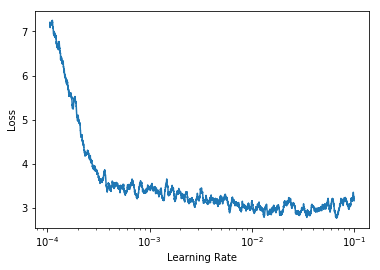

In [74]:
learner.plot_lrs(50)

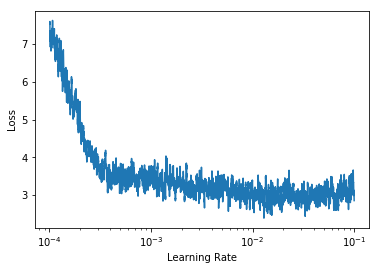

In [75]:
learner.plot_lrs(10)

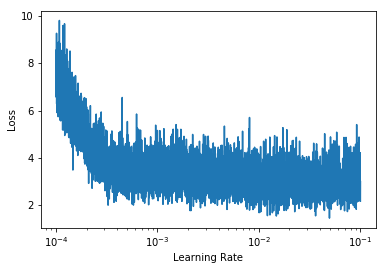

In [76]:
learner.plot_lrs(1)

In [81]:
del cfobj
torch.cuda.empty_cache()

In [82]:
cfobj=cf(n_users,n_emb_user,n_emb_movie,n_movies,min_rating,max_rating,autoenc_cols,dropout_e,hidden,dropouts,error_type="mse")
cfobj=cfobj.to(device)

In [83]:
wd=0
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-4,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,2000,0.25,cycle_mult=0)


In [84]:
learner.run_epochs(dltrain,dlvalid,2)

Batch:2000 4.091141331374645  
Batch:4000 3.707402782291174  
Batch:6000 3.5689200077851613  
Epoch:0 Learning rate 0.0005 Weight Decay 0 Train Loss:3.5625418037210337                 Valid Loss:3.1907934247568295 Train RMSE:1.8685625275356519 Valid RMSE:1.7774437076511664 Train MSE:3.5625418037210337 Valid MSE:3.1907934247568295                 Train MAE:1.5175240504720169 Valid MAE:1.422067172935227
Epoch:0 Learning rate 0.0005 Weight Decay 0 Train Loss:3.5625418037210337                 Valid Loss:3.1907934247568295 Train RMSE:1.8685625275356519 Valid RMSE:1.7774437076511664 Train MSE:3.5625418037210337 Valid MSE:3.1907934247568295                 Train MAE:1.5175240504720169 Valid MAE:1.422067172935227
Batch:2000 3.1687517136335375  
Batch:4000 3.1423105310201644  
Batch:6000 3.1082785296638806  
Epoch:1 Learning rate 0.0005 Weight Decay 0 Train Loss:3.107055777955356                 Valid Loss:3.0167215223860953 Train RMSE:1.754292530031096 Valid RMSE:1.728408753201324 Train MSE:3

In [78]:
torch.save(cfobj,f=f'{DATAPATH}/inter/cf_plus_model')
torch.save(learner,f=f'{DATAPATH}/inter/cf_plus_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/cf_plus_optimizer')
torch.save(cfobj.state_dict(),f'{DATAPATH}/inter/cf_plus_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/cf_plus_optimizer_state_dict')

In [79]:
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=5e-3,end_lr=5e-4,error_type="mse")

In [80]:
learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.005 Weight Decay 1e-06 Train Loss:2.820802423070153                 Valid Loss:2.724166905985469 Train RMSE:1.669516040585221 Valid RMSE:1.6415913162896578 Train MSE:2.820802423070153 Valid MSE:2.724166905985469                 Train MAE:1.3072781802044675 Valid MAE:1.2808635460767774
Epoch:0 Learning rate 0.005 Weight Decay 1e-06 Train Loss:2.820802423070153                 Valid Loss:2.724166905985469 Train RMSE:1.669516040585221 Valid RMSE:1.6415913162896578 Train MSE:2.820802423070153 Valid MSE:2.724166905985469                 Train MAE:1.3072781802044675 Valid MAE:1.2808635460767774
Epoch:1 Learning rate 0.0015811388300841897 Weight Decay 1e-06 Train Loss:2.0571134344615554                 Valid Loss:2.7101923172804456 Train RMSE:1.4242403438848554 Valid RMSE:1.6375177092688582 Train MSE:2.0571134344615554 Valid MSE:2.7101923172804456                 Train MAE:1.0686809491438833 Valid MAE:1.2712316268664898
Epoch:1 Learning rate 0.0015811388300841897 Weigh

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
